In [6]:
from collections import Counter
from collections import namedtuple, defaultdict
from pprint import pprint
from itertools import groupby
from copy import deepcopy
import re

import matplotlib.pyplot as plt
from Bio import SeqIO
from tqdm import tqdm_notebook

from vdj_walker import *

%matplotlib inline

In [7]:
"""Define constants"""
KMER_LEN = 7
PAIR_TRESHOLD = 15
COOL_TRESHOLD = 25
IMP_TRESHOLD = 10

"""Define data types"""
D = namedtuple('D', ['gene', 'J_gene', 'V_gene'])
Comb = namedtuple('Comb', ['gene', 'pos'])
DGene = namedtuple('DGene', ['read', 'gene'])
Kmer = namedtuple('Kmer', ['seq', 'j', 'v', 'dataset'])

def get_fa_header_value(line, *, index):
    return line.split('|')[index].split(':')[1]

def read_fa(file):
    for record in SeqIO.parse(file, 'fasta'):
        yield str(record.seq)

def read_J(file):
    for record in SeqIO.parse(file, 'fasta'):
        id_ = get_fa_header_value(record.id, index=1)
        if id_.startswith('cluster'):
           seq_len = len(str(record.seq).replace('-', ''))
        else:
            yield Comb(id_, seq_len)

def read_genes(file):
    for record in SeqIO.parse(file, 'fasta'):
        gene = record.id
        read = str(record.seq).upper()
        yield DGene(read, gene)

def read_V_headers(file):
    length = 0
    for record in SeqIO.parse(file, 'fasta'):
        if 'READ' in record.id:
            length = int(get_fa_header_value(record.id, index=3))
        elif 'GENE' in record.id:
            gene = get_fa_header_value(record.id, index=1)
            yield Comb(gene, length)

def split_kmers(read, size):
    for i in range(len(read) - size + 1):
        kmer = read[i : i + size]
        yield kmer

def read_info(csv):
    for line in csv:
        atrs = line.split()
        v = Comb(atrs[4], int(atrs[2]) - 1)
        j = Comb(atrs[8], int(atrs[5]) - 1)
        yield (v, j)

def fetch_d(vdj_dir: Path, i):
    clean_reads = read_fa(open(vdj_dir / 'cleaned_reads.fasta', 'r'))
    info = read_info(open(vdj_dir / 'alignment_info.csv'))
    
    for read, (v, j) in zip(clean_reads, info):
        d_read = read[v.pos + 1 : j.pos]
        yield (d_read, (j.gene, v.gene, i))

def read_iter():
    for i, vdj_dir in enumerate(vdj_dir_iter()):
        for read, info in fetch_d(vdj_dir, i):
            yield (read, info)

In [8]:
"""Kmers in known D segments"""
Ds = list(read_genes(open(gene_dir / 'IGHD-allP.fa', 'r')))
l = 0
n = 0
ds_kmers = set()
for i in Ds:
    l += len(i.read)
    n += 1
    for kmer in split_kmers(i.read, KMER_LEN):
        ds_kmers.add(kmer)
print(l / n)

24.318181818181817


In [9]:
"""Cut D segments from all datasets"""
raw_kmers = Counter()
for read, info in read_iter():
    for seq in split_kmers(read, KMER_LEN):
        raw_kmers[Kmer(seq, *info)] += 1

len(raw_kmers)

3039905

In [10]:
"""Count kmer pairs and delete kmers with less than PAIR_TRESHOLD number of occurences"""
kmer_pairs = Counter()
for kmer, n in raw_kmers.items():
    if n > PAIR_TRESHOLD:
        kmer_pairs[kmer.seq] += 1

len(kmer_pairs)

8350

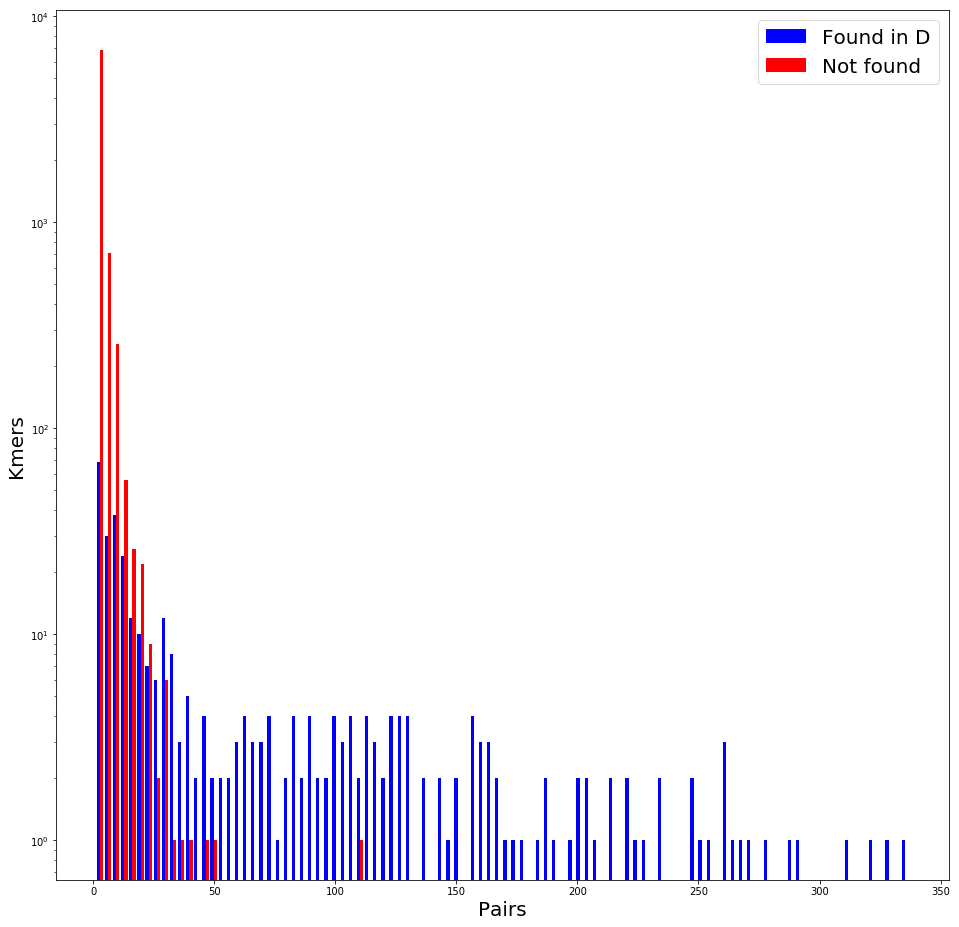

In [11]:
vdj_plot = plt.figure(figsize=(16, 16))

def ordinary_kmers():
    for q, i in kmer_pairs.items():
        if q in ds_kmers:
            yield i
        
def unique_kmers():
    for q, i in kmer_pairs.items():
        if q not in ds_kmers:
            yield i

plt.hist([ordinary_kmers() |> list, unique_kmers() |> list], 100, 
         alpha=1, color=['b', 'r'], label=['Found in D', 'Not found'], log=True)

plt.xlabel('Pairs', fontsize=20)
plt.ylabel('Kmers', fontsize=20)
plt.legend(fontsize=20)

In [3]:
"""Filter kmers with small number of pairs"""
good = set()
for kmer, n in kmer_pairs.items():
    if n >= 20:
        good.add(kmer)
print(len(good))
good

0


set()

In [12]:
def read_imp(read):
    for kmer in split_kmers(read, KMER_LEN):
        if kmer not in ds_kmers:
            if kmer in good:
                yield kmer_pairs[kmer]
            else:
                yield 0
        else:
            yield kmer_pairs[kmer]

def is_good(n):
    return n >= IMP_TRESHOLD
            
def strip_read(read):
    global bad_counter
    read_map = list(enumerate(read_imp(read)))
    
    ids = (dropwhile((x) -> x[1] < IMP_TRESHOLD, read_map) |>
           takewhile$((x) -> x[1] >= IMP_TRESHOLD, ?)) |> map$((x)->x[0], ?)
    ids = list(ids)
    if not ids:
        bad_counter += 1
        return ''
    return read[ids[0]:(ids[-1] + KMER_LEN)]

def split_read(read):
    global bad_counter, distribution, max_seq_counter
    
    read_map = list(enumerate(read_imp(read) |> map$(is_good, ?)))
    
    for i, imp_id in read_map:
        #print(i, imp_id)
        distribution[i][int(imp_id)] += 1
        #print(distribution)
        
    #pprint(read_map)
    bad_counter += len(list(filter((x)->not x[1], read_map)))
    
    gb = groupby(read_map, (x)->x[1])
    gb = gb |> map$((x)->(x[0], list(x[1])), ?) |> list
    #pprint(gb)
    #print('ids:')
    max_good_seq = 0
    for ids in filter((x)->x[0], gb):
        ids = ids[1] |> map$((x)->x[0], ?) |> list
        #print('length: ', len(ids))
        max_good_seq = max(max_good_seq, len(ids))
        #print(ids)
        yield read[ids[0]:(ids[-1] + KMER_LEN)]
    if max_good_seq > 0:
        max_seq_counter[max_good_seq] += 1

def strip_timofey(read):
    vs = []
    read_map = list(read_imp(read))
    for i in range(len(read)):
        for j in range(len(read) - 1 - int(i == 0), i + 1, -1):
            trash = read_map[:i] + read_map[j:]
            m1 = sum(trash) / len(trash)
            d_seg = read_map[i:j]
            m2 = sum(d_seg) / len(d_seg)
            vs.append((m2 - m1, i, j))
    i, j = max(vs)[1:]
    return read[i : j - 1 + KMER_LEN]

In [ ]:
"""DEBUG - don't eval"""
kmer_pairs_real = deepcopy(kmer_pairs)
good_real = deepcopy(good)

bad_counter = 0
KMER_LEN = 2
IMP_TRESHOLD = 1
kmer_pairs = Counter({'AC': 2, 'CG': 3, 'GA': 2,
                      'AT': 3, 'TC': 2, 'CA': 2})
good = kmer_pairs.keys()
seq = 'AACGAATCATT'

In [190]:
"""After Debug exec:"""
kmer_pairs = kmer_pairs_real
good = good_real
IMP_TRESHOLD = 5

In [13]:
"""Clean trash from d segments"""
bad_counter = 0
cleaned_reads = set()
before_len = Counter()
after_len = Counter()
distribution = [[0, 0] for _ in range(200)]
max_seq_counter = Counter()

for read, info in read_iter():
    before_len[len(read)] += 1
    for clean_read in split_read(read):
        after_len[len(clean_read)] += 1
        cleaned_reads.add((clean_read, info))

print(len(cleaned_reads))
print(bad_counter)

186862
5239429


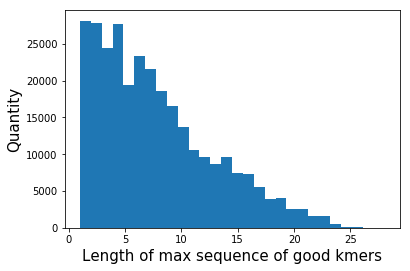

In [21]:
max_seq_plot = plt.figure()
_ = plt.hist(max_seq_counter.elements() |> list, bins=28)
plt.xlabel('Length of max sequence of good kmers', fontsize=15)
plt.ylabel('Quantity', fontsize=15)

In [285]:
max_seq_plot.savefig('max_good_seq2.png')

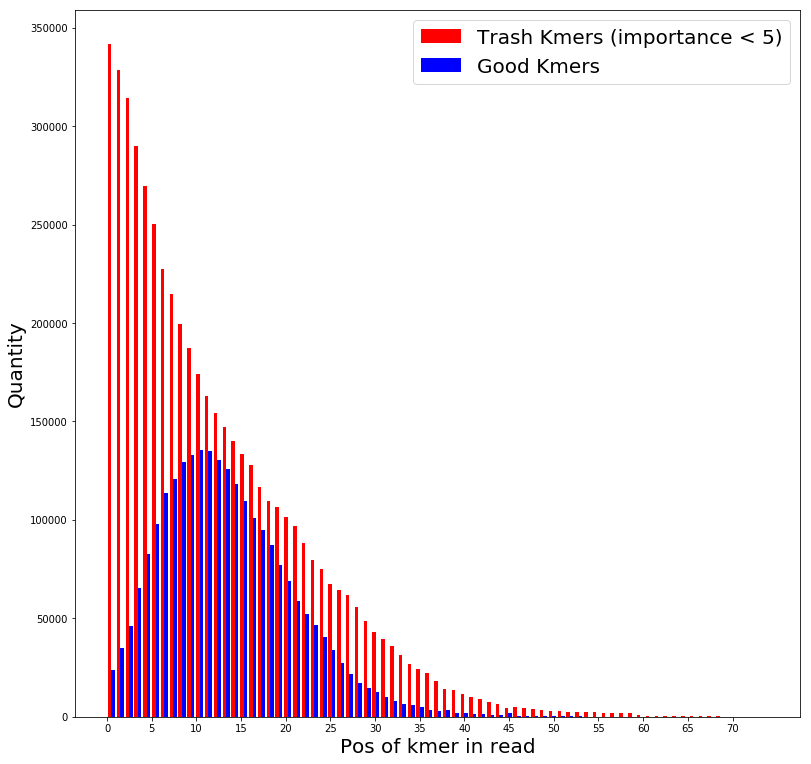

In [22]:
dist_fig = plt.figure(figsize=(13, 13))

def sts(n):
    for i in range(75):
        hmuch = distribution[i][n]
        for j in range(hmuch):
            yield i

trash, read_d = (list(sts(i)) for i in range(2))
_ = plt.hist([trash, read_d], bins = 75, 
             color=('r', 'b'), label=('Trash Kmers (importance < 5)', 'Good Kmers'))

plt.xlabel('Pos of kmer in read', fontsize=20)
plt.ylabel('Quantity', fontsize=20)
plt.legend(fontsize=20)
_ = plt.xticks(range(0, 75, 5))

In [246]:
dist_fig.savefig('importance_distribution.png')

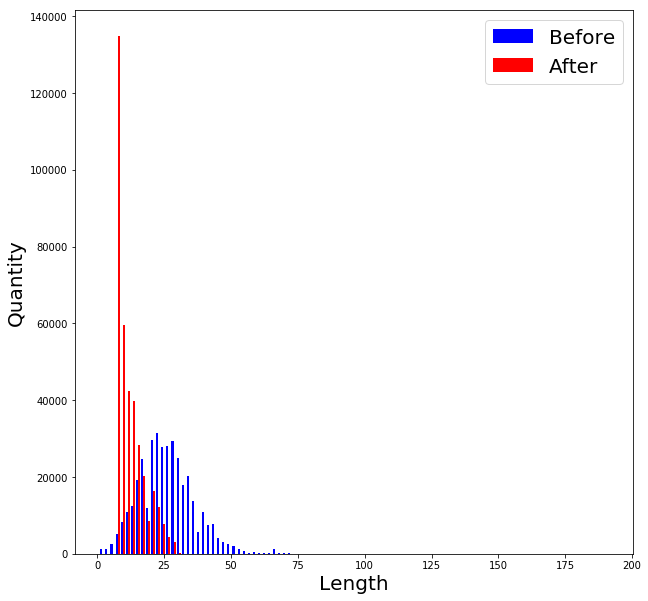

In [14]:
len_plot = plt.figure(figsize=(10, 10))

plt.hist([before_len.elements() |> list, after_len.elements() |> list], 100,
         alpha=1, color=['b', 'r'], label=['Before', 'After'], log=False)

plt.xlabel('Length', fontsize=20)
plt.ylabel('Quantity', fontsize=20)
plt.legend(fontsize=20)
#plt.xticks(range(100, 100))

In [128]:
len_plot.savefig('len2.png')

In [26]:
"""Filter kmers with small number of pairs"""
cool = set()
for kmer in good:
    if kmer not in ds_kmers:
        cool.add(kmer)
print(len(cool))
cool

29


{'AGCTGCC',
 'AGGGGGG',
 'CGGGGGG',
 'CGTATTA',
 'GATAGCA',
 'GATTACT',
 'GCTACGG',
 'GCTGGTC',
 'GGAGGGG',
 'GGCAGTG',
 'GGCTGGC',
 'GGGAGGG',
 'GGGGAGC',
 'GGGGAGG',
 'GGGGGAT',
 'GGGGGGA',
 'GGGGGGC',
 'GGGGGGG',
 'GGGGGGT',
 'GGGGGTG',
 'GGGGTGG',
 'GGTACGG',
 'GGTGGGA',
 'GGTTACC',
 'GTTATTC',
 'TAGGGGG',
 'TGGGGGG',
 'TGGTACC',
 'TGGTACG'}

In [ ]:
kmer_id = {kmer: i for kmer, i in zip(cool, range(len(cool)))}
kmer_id

In [55]:
"""Dict [read]: kmers in it (combination of)"""
cool_reads = {}
for read, info in cleaned_reads:
    n = tuple(kmer for kmer in cool if kmer in read)
    if n:
        cool_reads[(read, info)] = n

len(cool_reads)

44078

In [56]:
"""Dict [combination of kmers]: reads with it"""
comb_reads = defaultdict(list)
for read, comb in cool_reads.items():
    comb_reads[comb].append(read)
comb_reads

defaultdict(list,
            {('AGCTGCC',): [('ATTGTAGTGGTGGTAGCTGCC',
               ('IGHJ3*02', 'IGHV1-2*04', 5)),
              ('ATAGCAGCAGCTGCC', ('IGHJ5*02', 'IGHV1-18*01', 11)),
              ('TGTAGTAGTACCAGCTGCC', ('IGHJ4*02', 'IGHV4-34*02', 6)),
              ('TTGTAGTAGTACCAGCTGCC', ('IGHJ4*02', 'IGHV3-30-3*03', 13)),
              ('AGCTGCC', ('IGHJ5*02', 'IGHV3-33*06', 8)),
              ('AGCTGCC', ('IGHJ4*02', 'IGHV3-23D*02', 6)),
              ('TTGTAGTAGTACCAGCTGCC', ('IGHJ6*02', 'IGHV4-61*01', 16)),
              ('ATTGTGGTGGTGGTAGCTGCC', ('IGHJ5*02', 'IGHV6-1*02', 3)),
              ('TATTGTAGTAGTACCAGCTGCC', ('IGHJ3*02', 'IGHV1-46*01', 16)),
              ('ATTGTAGTAGTACCAGCTGCC', ('IGHJ4*02', 'IGHV4-61*02', 0)),
              ('TGGTGGTAGCTGCC', ('IGHJ4*02', 'IGHV3-9*01', 15)),
              ('TGTAGTAGTACCAGCTGCC', ('IGHJ4*02', 'IGHV1-3*02', 17)),
              ('GATATTGTAGTAGTACCAGCTGCC', ('IGHJ4*02', 'IGHV4-59*08', 8)),
              ('ATATTGTAGTAGTACCAGCTGCC', 

In [57]:
cool_combs = Counter()
for comb in cool_reads.values():
    cool_combs[comb] += 1

In [58]:
"""Filter combs where all reads there are from one dataset."""
cool_dataset = {read: combs for read, combs in comb_reads.items()
                if len(set(map((x)->x[1][2], combs))) != 1}
print(len(cool_dataset.keys()))
#cool_dataset = [kmers for kmers in cool_dataset.keys() if len(kmers) != 1]

154


In [64]:
all_reads = {comb: reads for comb, reads in cool_dataset.items()
             if len(comb) > 5}
len(all_reads)

4

In [65]:
cool_vj = {read: combs for read, combs in cool_dataset.items()
           if len(set(map((x)->x[1][:2], combs))) != 1}
print(len(cool_vj))
cool_vj

154


{('AGCTGCC',): [('ATTGTAGTGGTGGTAGCTGCC', ('IGHJ3*02', 'IGHV1-2*04', 5)),
  ('ATAGCAGCAGCTGCC', ('IGHJ5*02', 'IGHV1-18*01', 11)),
  ('TGTAGTAGTACCAGCTGCC', ('IGHJ4*02', 'IGHV4-34*02', 6)),
  ('TTGTAGTAGTACCAGCTGCC', ('IGHJ4*02', 'IGHV3-30-3*03', 13)),
  ('AGCTGCC', ('IGHJ5*02', 'IGHV3-33*06', 8)),
  ('AGCTGCC', ('IGHJ4*02', 'IGHV3-23D*02', 6)),
  ('TTGTAGTAGTACCAGCTGCC', ('IGHJ6*02', 'IGHV4-61*01', 16)),
  ('ATTGTGGTGGTGGTAGCTGCC', ('IGHJ5*02', 'IGHV6-1*02', 3)),
  ('TATTGTAGTAGTACCAGCTGCC', ('IGHJ3*02', 'IGHV1-46*01', 16)),
  ('ATTGTAGTAGTACCAGCTGCC', ('IGHJ4*02', 'IGHV4-61*02', 0)),
  ('TGGTGGTAGCTGCC', ('IGHJ4*02', 'IGHV3-9*01', 15)),
  ('TGTAGTAGTACCAGCTGCC', ('IGHJ4*02', 'IGHV1-3*02', 17)),
  ('GATATTGTAGTAGTACCAGCTGCC', ('IGHJ4*02', 'IGHV4-59*08', 8)),
  ('ATATTGTAGTAGTACCAGCTGCC', ('IGHJ5*02', 'IGHV4-34*01', 1)),
  ('GTAGTAGTACCAGCTGCC', ('IGHJ6*02', 'IGHV3-49*03', 14)),
  ('CAGCAGCTGCC', ('IGHJ4*02', 'IGHV4-34*11', 11)),
  ('TGTAGTGGTGGTAGCTGCC', ('IGHJ6*02', 'IGHV3-23*04', 15)

In [66]:
def viz(read, kmers):
    print(read)
    for kmer in kmers:
        for pos in (m.start() for m in re.finditer(kmer, read)):
            print(' ' * (pos - 1), kmer)
    print()

for comb, reads in all_reads.items():
    for read in reads:
        viz(read[0], comb)

AGGGGGGGAGGGG
 AGGGGGG
     GGGAGGG
    GGGGAGG
      GGAGGGG
  GGGGGGA
 GGGGGGG

AGGGGGGGGAGGGG
 AGGGGGG
      GGGAGGG
     GGGGAGG
       GGAGGGG
   GGGGGGA
 GGGGGGG

TAGGGGGGGGAGGG
 AGGGGGG
       GGGAGGG
      GGGGAGG
 TAGGGGG
    GGGGGGA
  GGGGGGG

TAGGGGGGGAGGG
 AGGGGGG
      GGGAGGG
     GGGGAGG
 TAGGGGG
   GGGGGGA
  GGGGGGG

TAGGGGGGGAGGG
 AGGGGGG
      GGGAGGG
     GGGGAGG
 TAGGGGG
   GGGGGGA
  GGGGGGG

TAGGGGGGGGAGGG
 AGGGGGG
       GGGAGGG
      GGGGAGG
 TAGGGGG
    GGGGGGA
  GGGGGGG

TAGGGGGGGTGG
 AGGGGGG
   GGGGGGT
 TAGGGGG
    GGGGGTG
  GGGGGGG
     GGGGTGG

TAGGGGGGGTGG
 AGGGGGG
   GGGGGGT
 TAGGGGG
    GGGGGTG
  GGGGGGG
     GGGGTGG

TAGGGGGGGGTGG
 AGGGGGG
    GGGGGGT
 TAGGGGG
     GGGGGTG
  GGGGGGG
      GGGGTGG

TAGGGGGGGGTGG
 AGGGGGG
    GGGGGGT
 TAGGGGG
     GGGGGTG
  GGGGGGG
      GGGGTGG

TAGGGGGGGTGG
 AGGGGGG
   GGGGGGT
 TAGGGGG
    GGGGGTG
  GGGGGGG
     GGGGTGG

TGGGGGGGGGAGGGG
       GGGAGGG
      GGGGAGG
 TGGGGGG
        GGAGGGG
    GGGGGGA
 GGGGGGG

TTGGGGGGG

In [61]:
def coverage(read, kmers):
    a = [0] * len(read)
    for kmer in kmers:
        for pos in (m.start() for m in re.finditer(kmer, read)):
            a[pos : pos + len(kmer)] = [1] * len(kmer)
    print(read)
    print(''.join(map(str, a)))
    print()
    return sum(a)

In [67]:
cov_reads = Counter()
for comb, reads in all_reads.items():
    for read in reads:
        cov_reads[read] = coverage(read[0], comb) / len(read[0]) * 100

cov_reads.most_common()

AGGGGGGGAGGGG
1111111111111

AGGGGGGGGAGGGG
11111111111111

TAGGGGGGGGAGGG
11111111111111

TAGGGGGGGAGGG
1111111111111

TAGGGGGGGAGGG
1111111111111

TAGGGGGGGGAGGG
11111111111111

TAGGGGGGGTGG
111111111111

TAGGGGGGGTGG
111111111111

TAGGGGGGGGTGG
1111111111111

TAGGGGGGGGTGG
1111111111111

TAGGGGGGGTGG
111111111111

TGGGGGGGGGAGGGG
111111111111111

TTGGGGGGGGAGGGG
011111111111111



[(('AGGGGGGGAGGGG', ('IGHJ4*02', 'IGHV1-69*12', 12)), 100.0),
 (('AGGGGGGGGAGGGG', ('IGHJ4*02', 'IGHV4-34*08', 15)), 100.0),
 (('TAGGGGGGGGAGGG', ('IGHJ5*02', 'IGHV4-39*07', 13)), 100.0),
 (('TAGGGGGGGAGGG', ('IGHJ4*02', 'IGHV4-59*08', 10)), 100.0),
 (('TAGGGGGGGAGGG', ('IGHJ4*02', 'IGHV4-31*03', 10)), 100.0),
 (('TAGGGGGGGGAGGG', ('IGHJ5*02', 'IGHV4-59*01', 13)), 100.0),
 (('TAGGGGGGGTGG', ('IGHJ3*02', 'IGHV4-59*01', 1)), 100.0),
 (('TAGGGGGGGTGG', ('IGHJ6*02', 'IGHV3-49*05', 12)), 100.0),
 (('TAGGGGGGGGTGG', ('IGHJ6*02', 'IGHV3-30-3*03', 12)), 100.0),
 (('TAGGGGGGGGTGG', ('IGHJ4*02', 'IGHV4-34*01', 6)), 100.0),
 (('TAGGGGGGGTGG', ('IGHJ3*02', 'IGHV1-8*01', 9)), 100.0),
 (('TGGGGGGGGGAGGGG', ('IGHJ5*02', 'IGHV3-33*04', 8)), 100.0),
 (('TTGGGGGGGGAGGGG', ('IGHJ4*02', 'IGHV1-18*01', 12)), 93.33333333333333)]